In this class I perform Partial Least Squares Discriminant Analysis (PLS-DA) on the data.

# About PLS-DA
It can be regarded as **multivariate dimensionality-reduction tool**
It has been recommended for use in omics data analyses. PLS-DA is gaining popularity in metabolomics and in other integrative omics analyses.

PLS-DA can be thought of as a supervised version of Principal Component Analysis (PCA) in the sense that it achieves dimensionality reduction but with full awareness of the class labels. Besides its use for dimensionality-reduction, it can be adapted to be used for feature selection as well as for classification.
[Article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7724830/#:~:text=Background-,Partial%20Least%2DSquares%20Discriminant%20Analysis%20(PLS%2DDA)%20is,use%20in%20omics%20data%20analyses)

PLS-DA preserves in its first PC component as much covariance as possible between the original data and its labeling.

### In this file:
First data is projected onto the latent space using Partial Least Squares and then classification is made using Logistic Regression.


In [1]:
from sklearn.cross_decomposition import PLSRegression
from methods.helper import *
import plotly.express as px
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from methods.feature_selection import *
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\mjgoj\miniconda3\Lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [2]:
def plot_scores(x_scores, y):
    """
    Plot the scores of the PLS model
    :param x_scores: The scores of the PLS model
    Scores represent the projections of the samples (onto the PLS components (latent variables)
    :param y: The class of each sample
    :return: None
    """
    
    color_map = {0: 'deepskyblue', 1: 'lightsalmon', 2: 'tomato'}
    
    # Create a 3D plot if the scores have 3 components
    if x_scores.shape[1] == 3:
    
        # The scores describe position of each sample in each determined latent variable (LV).
        # Shape of the scores: (n_samples, n_components)
        scores = pd.DataFrame(x_scores, columns=[0, 1, 2])
        scores = scores.copy()
        scores["class"] = pd.Categorical(y)
    
        fig = px.scatter_3d(
            scores, x=0, y=1, z=2,
            color="class", color_discrete_map=color_map,
            labels={0: 'PLS1', 1: 'PLS2', 2: 'PLS3'},
            title="3D Scatter Plot of PLS-DA Scores",
            opacity=0.8, size_max=8,
        )
        fig.update_layout(
            scene=dict(xaxis_title='PLS1', yaxis_title='PLS2', zaxis_title='PLS3'
        ), overwrite=True)
        fig.show()
    
    # Create a 2D plot if the scores have 2 components
    elif x_scores.shape[1] == 2:
        scores = pd.DataFrame(x_scores, columns=[0, 1])
        scores["class"] = pd.Categorical(y)
        fig = px.scatter(
            scores, x=0, y=1,
            color="class", color_discrete_map=color_map,
            labels={0: 'PLS1', 1: 'PLS2'},
            title="2D Scatter Plot of PLS-DA Scores"
        )
        fig.update_layout(overwrite=True, xaxis_title='PLS1', yaxis_title='PLS2')
        fig.show()
        
    elif x_scores.shape[1] == 1:
        scores = pd.DataFrame(x_scores, columns=[0])
        scores["class"] = pd.Categorical(y)
        # Add a very small jitter to the scores (y) to avoid overlapping points
        y = scores["class"].cat.codes + np.random.normal(0, 0.1, len(scores["class"]))
        fig = px.scatter(
            scores, x=0, y=y,
            color="class", color_discrete_map=color_map,
            labels={0: 'PLS1'}, title="1D Scatter Plot of PLS-DA Scores"
        )
        fig.update_layout(overwrite=True, xaxis_title='PLS1', yaxis_title='Class')
        fig.show()
    else:
        print("The scores have more than 3 components. Cannot plot.")

In [3]:
def PLS(x, y, n_components=3):
    """
    :param x: The input data
    :param y: The class of each sample
    :param n_components: The number of latent variables to use
    :return: The PLS model (Partial Least Squares)
    """
    PLS_regression = PLSRegression(n_components=n_components, scale=False)
    PLS_regression.fit(x, y)

    # There are 3 columns for each class  (and thus latent variable) and n rows for each variable
    # Weights describe the contribution of each variable to each LV
    print("Shape of the weights: ", PLS_regression.x_weights_.shape)
    # The scores describe position of each sample in each determined latent variable (LV).
    print("Shape of the weights: ", PLS_regression.x_scores_.shape)
    return PLS_regression

### Load Data

In [9]:
lipidomics, metabolomics, proteomics = load_data()
X_train_, X_test_, Y_train_, y_test_ = concatenate_data(
    lipidomics, metabolomics, proteomics, num_classes=3
)
# Standardize the data
X_train_ = standardize(X_train_)
X_test_ = standardize(X_test_)

In [10]:
pls_3 = PLS(X_train_, Y_train_)
plot_scores(pls_3.x_scores_, Y_train_)

Shape of the weights:  (1112, 3)
Shape of the weights:  (58, 3)


### Step 2. Classification using Logistic Regression

In [18]:
class PLSLogistic:
    
    def __init__(self, x_train, y_train, num_components=None):
        self.x_train = x_train
        self.y_train = y_train
        
        # Number of components to use in PLS
        
        if not num_components:
            self.tune_components()
        else:
            self.n_components = num_components
        
        # Dimensionality reduction using PLS
        self.pls =PLS(self.x_train, self.y_train, self.n_components)
        # Initialize the logistic regression model
        self.logistic = LogisticRegression(multi_class='ovr', max_iter=1000)
        
    def tune_components(self):
        # Parameters of PLS to try
        param_grid = {
            'n_components': list(range(1, min(self.x_train.shape[1], self.x_train.shape[0])))
        }
        # Initialize PLSRegression without specifying n_components
        pls = PLSRegression(scale=False)

        # Create a cross-validation strategy
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

        # Use GridSearchCV to find the best number of components
        grid_search = GridSearchCV(
            estimator=pls, param_grid=param_grid, 
            scoring='f1', cv=cv, n_jobs=-1)
        
        # Fit the grid search to the data
        grid_search.fit(self.x_train, self.y_train)

        # Retrieve the best number of components and set up the PLS model with it
        self.n_components = grid_search.best_params_['n_components']
        self.pls = PLS(self.x_train, self.y_train, self.n_components)
        print(f"Best number of components: {self.n_components}")
        
        
    def train(self):
        # Fit the model
        self.logistic.fit(self.pls.x_scores_, self.y_train)
    
    def predict(self, x_test):
        # Transform the test data using the PLS model
        x_scores = self.pls.transform(x_test)
        return self.logistic.predict(x_scores)
    
    def plot_confusion_matrix(self, x_test, y_test):
        y_pred = self.predict(x_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="GnBu")
        plt.show()
        
    def plot_scores(self, x_test, y_test):
        x_scores = self.pls.transform(x_test)
        plot_scores(x_scores, y_test)   
    
    def evaluate(self, x_test, y_test):
        y_pred = self.predict(x_test)
        evaluate_model(y_test, y_pred)

### Regression with Hyperparameter Tuning

In [22]:
# Here the training data is plotted
pls_logistic_model = PLSLogistic(X_train_, Y_train_, 3)
pls_logistic_model.plot_scores(X_train_, Y_train_)

Shape of the weights:  (1112, 3)
Shape of the weights:  (58, 3)


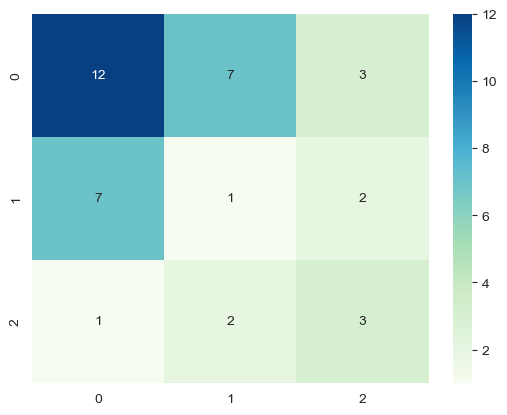

Accuracy of the model: 0.4211
Recall of the model: 0.4211
Precision of the model: 0.4187
Weighted F1 score of the model: 0.4173
Matthews Correlation Coefficient of the model: 0.0235


In [23]:
# And here the test data is plotted
pls_logistic_model.train()
pls_logistic_model.plot_confusion_matrix(X_test_, y_test_)
pls_logistic_model.evaluate(X_test_, y_test_)

### No Hyperparameter Tuning

Shape of the weights:  (1112, 1)
Shape of the weights:  (58, 1)
Best number of components: 1
Shape of the weights:  (1112, 1)
Shape of the weights:  (58, 1)


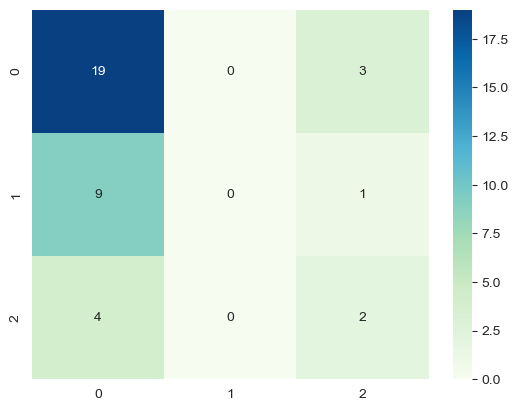

Accuracy of the model: 0.5526
Recall of the model: 0.5526
Precision of the model: 0.7799
Weighted F1 score of the model: 0.6452
Matthews Correlation Coefficient of the model: 0.1031


In [25]:
# Here the training data is plotted
pls_logistic_model = PLSLogistic(X_train_, Y_train_, num_components=None)
pls_logistic_model.plot_scores(X_train_, Y_train_)

# And here the test data is plotted
pls_logistic_model.train()
pls_logistic_model.plot_confusion_matrix(X_test_, y_test_)
pls_logistic_model.evaluate(X_test_, y_test_)